In [1]:
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.image as mpimg
from os import listdir
import os
from sklearn.model_selection import train_test_split  
from sklearn.metrics import classification_report, confusion_matrix,precision_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler  
np.set_printoptions(threshold=10)
np.set_printoptions(threshold=np.nan)

%matplotlib inline

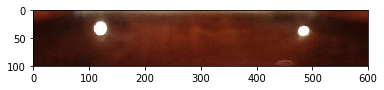

In [2]:
def get_label(path):
    return int(path.split('/')[-1].split('_')[0])

source_path = "C:/Users/tomas.chladek/Documents/Personal/Uni/Master/3rd/ROZ/irises_MICHE_iPhone5_norm/"
onlyfiles = [f for f in listdir(source_path)]

def get_fileName(user,image_number):
    counter = 0;
    for file in onlyfiles:
        if get_label(file) == user:
            counter += 1
            if counter == image_number:
                return source_path + file
                break

fileName = get_fileName(1,1)
original_image = mpimg.imread(fileName)
plt.imshow(original_image)

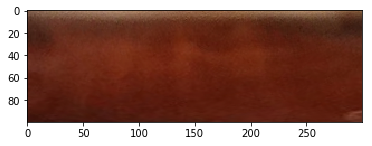

In [3]:
def crop(img):
    return img[:, 150:450]   

cropped_image = crop(original_image.copy())
plt.imshow(cropped_image)

In [4]:
# from PIL import Image, ImageEnhance

# image = Image.open(fileName)
# enhancer_object = ImageEnhance.Sharpness(image)
# out = enhancer_object.enhance(2.0)
# new_image = np.array(out.getdata())
# new_image.shape(100,300)
# # new_image = np.array(out.getdata())[..., 2] 
# # show_image(new_image)

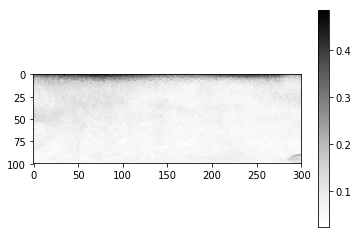

In [5]:
 def show_image(img):
    plt.imshow(img, cmap="Greys")
    plt.colorbar() 

new_image = cropped_image.copy()
new_image = new_image[..., 2] 
show_image(new_image)

In [6]:
def flatten(image):
    flat_list = []
    for sub_list in image:
        for item in sub_list:
            flat_list.append(item)
    return flat_list

def show_histogram(image):
    flat_list = flatten(image)

    n, bins, patches = plt.hist(x=flat_list, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('intensity')
    plt.ylabel('Frequency')
    plt.title('Color intensity')

In [7]:
np.average(new_image)

0.09056104

In [8]:
np.median(new_image)

0.07058824

In [9]:
np.std(new_image)

0.064992435

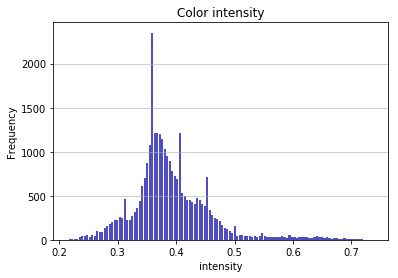

In [10]:
def filter_spectrum(image):
    new_image = image.copy()
    median = np.median(new_image)
    std = np.std(new_image)
    limit_high = median + std
    limit_low = median - std
    new_image[image > limit_high] = limit_high
    new_image[image < limit_low] = limit_low
    return new_image

def normalize(image):
    min_value = np.min(image)
    new_image = image - min_value
    return new_image

def get_channel(img,channel):
    new_image = img.copy()
    single_channel = new_image[..., channel]
    return single_channel

test_image = get_channel(cropped_image,0)
show_histogram(test_image)

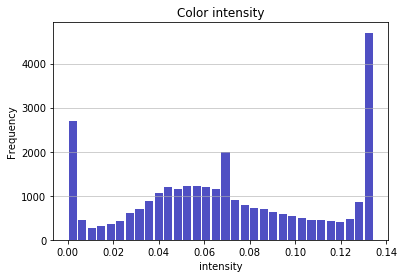

In [11]:
test_image = get_channel(cropped_image,0)
test_image = filter_spectrum(test_image)
test_image = normalize(test_image)
show_histogram(test_image)

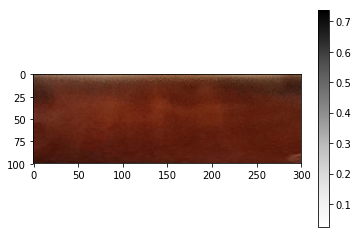

In [12]:
show_image(cropped_image)

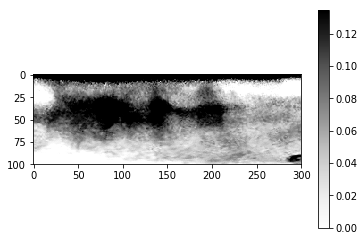

In [13]:
show_image(test_image)

In [14]:
def select_data(img, factor):
    new_image = img.copy()
    flatted_image = flatten(new_image);
    sorted_array = np.sort(flatted_image)
    
    length = len(sorted_array)
    last_item_index = int(-length*factor)
    upper_threshold = sorted_array[last_item_index]

#     print(upper_threshold)
#     print(sorted_array[-1])
#     print(sorted_array[int(length/2)])
    
    new_image[new_image >= upper_threshold] = 1
    new_image[new_image < upper_threshold] = 0
    return new_image

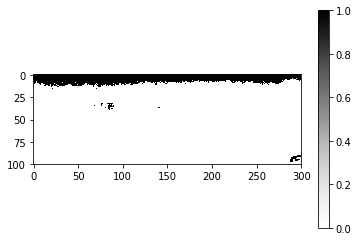

In [15]:
# MASK
def get_mask(img,channel):
    new_image = img.copy()
    new_image = new_image[..., channel] 
    new_image = filter_spectrum(new_image)
    new_image = normalize(new_image)
    new_image = select_data(new_image,0.1)
    return new_image

mask_image = get_mask(cropped_image,1)
show_image(mask_image)

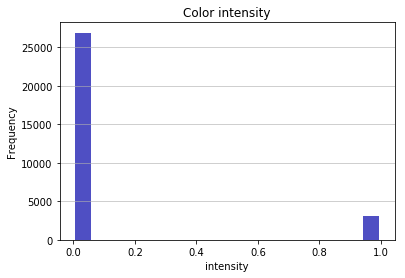

In [16]:
show_histogram(mask_image)

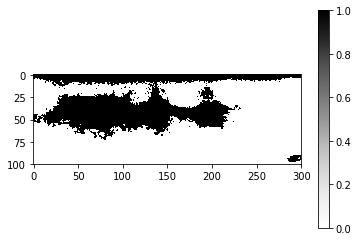

In [17]:
raster_image = select_data(test_image,0.30);
show_image(raster_image)

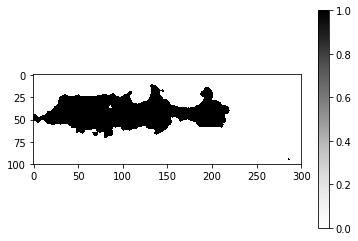

In [18]:
def remove_mask(img,mask):
    new_image = img.copy()
    for row in range(100):
        for column in range(300):
            if mask[row,column] > 0:
                new_image[row,column] = 0
    
    new_image = scipy.ndimage.median_filter(new_image, 5)    
    return new_image


masked_image = remove_mask(raster_image,mask_image)
show_image(masked_image)

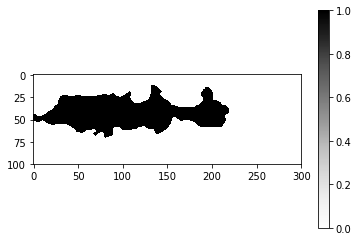

In [19]:
def final_product(img):
    new_image = img.copy()
    new_image = crop(new_image)
    new_image = get_channel(new_image,0)
    new_image = filter_spectrum(new_image)
    new_image = normalize(new_image)
    new_mask = get_mask(crop(img.copy()),1)
    new_image = select_data(new_image,0.3)
    new_image = remove_mask(new_image,new_mask)
    new_image = scipy.ndimage.median_filter(new_image, 5)        
    return new_image

show_image(final_product(original_image))

In [23]:
def get_classifier(image):
    classifier = []
    for column in range(0,300):
        counter = 0
        for row in range(0,100):
            if image[row,column] > 0:
                counter += 1
        classifier.append(counter)
    return classifier

def get_score(data,labels,iterations):
    error = []
    for i in range(1, iterations):  
        data_train, data_test, labels_train, labels_test = train_test_split(data[:], labels[:], test_size=0.50)  
        classifier = KNeighborsClassifier(n_neighbors=1)  
        classifier.fit(data_train, labels_train)
        labels_pred = classifier.predict(data_test) 
        error.append(precision_score(labels_test, labels_pred, average='weighted'))
    return np.average(error)  

def store_images(source_path,target_path):
    create_folder(target_path)
    onlyfiles = [f for f in listdir(source_path)]
    dataset = []
    labels = []
    data = []
    for fileName in onlyfiles:
        full_path =source_path + "/" +fileName
        img = mpimg.imread(full_path)
        
        image_processed = final_product(img)
        classifier = get_classifier(image_processed)
        label = get_label(fileName)
        labels.append(label)
        data.append(classifier)
        dataset.append([label,classifier])
                
        mpimg.imsave(target_path + "/" + fileName, image_processed, cmap='Greys')
    return (dataset,labels,data)
    

def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)        

#number = input()        
#source_path = "C:\\Users\\tomas.chladek\\Documents\\Personal\\Uni\\Master\\3rd\\ROZ\\irises_MICHE_iPhone5_norm"
target =  input()#source_path + "C:\\Users\\tomas.chladek\\Documents\\Personal\\Uni\\Master\\3rd\ROZ\\irises_red_normalized" + str(number)
(dataset,labels,data) = store_images(source_path,target)

get_score(data,labels,100)

998


C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklear

C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklear

C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklear

C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomas.chladek\Documents\Personal\Uni\Master\3rd\ROZ\irisClassifier\__venv__\lib\site-packages\sklear

0.6160805214654288

In [22]:
len(data)

1626